# Chapter 6 - Using gate-based Quantum Computers - Some basic quantum algorithms 
2. Single and Multiple qubit gates and circuits

© 2021, 2022 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import numpy as np

In [5]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [6]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [7]:
### Please run available_devices() and correct any device names below

def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system6.1','Advantage_system4.1','DW_2000Q_6','Aspen-M-1','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [8]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [9]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [10]:
# this function has been updated with an additional display_binary flag
def run_circuit(device, circuit, shots, s3_folder, display_binary=True):
    import matplotlib.pyplot as plt
    %matplotlib inline
    result = device.run(circuit, shots=shots, s3_destination_folder=s3_folder).result()
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [11]:
def draw_bloch(q):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")

    print('Matrix:')
    print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    print(' ')
    print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
    print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    print('Bloch Sphere:')
    plt.show()
    return(q)

In [67]:
def draw_circuit(circ):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r)

In [52]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

## Single Qubit Quantum Gates and Circuits

In [14]:
circ=Circuit().i(0)

T  : |0|
        
q0 : -I-

T  : |0|

Additional result types: StateVector
Matrix:
[[1.+0.j]
 [0.+0.j]]
 
State Vector: |psi> = sqrt( [1.] ) |0> + ( sqrt( [0.] )) e^i [0.] pi |1>
 
Bloch Sphere:


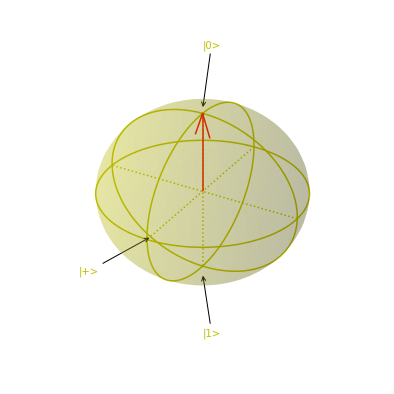

In [15]:
draw_circuit(circ)

T  : |0|1|
          
q0 : -H-Z-

T  : |0|1|

Additional result types: StateVector
Matrix:
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [1.] pi |1>
 
Bloch Sphere:


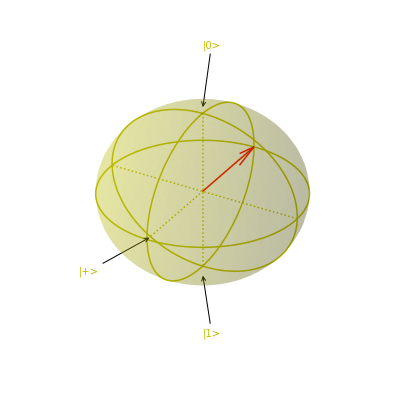

In [16]:
circ=Circuit().h(0).z(0)
draw_circuit(circ)

T  : |0|1|
          
q0 : -H-T-

T  : |0|1|

Additional result types: StateVector
Matrix:
[[0.70710678+0.j ]
 [0.5       +0.5j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [0.25] pi |1>
 
Bloch Sphere:


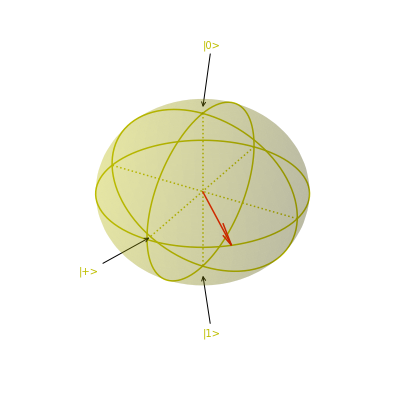

In [17]:
circ=Circuit().h(0).t(0)
draw_circuit(circ)

This exercise starts with the $|0\rangle$ state and then we apply a NOT operation (X gate) to move the qubit to the 
$|1\rangle$ state, then apply the Hadamard gate (H gate) and finally the S gate. The matrix equivalent is below.

$$
\left[\begin{array}{cc} 
1 & 0\\
0 & i
\end{array}\right]
\left[\begin{array}{cc} 
0.7071 & 0.7071\\
0.7071 & -0.7071
\end{array}\right]
\left[\begin{array}{cc} 
0 & 1\\ 
1 & 0
\end{array}\right]
\left[\begin{array}{cc} 
1 \\ 
0
\end{array}\right]
=
\left[\begin{array}{cc} 
0.7071 \\ 
-0.7071i
\end{array}\right]
$$ 

T  : |0|1|2|
            
q0 : -X-H-S-

T  : |0|1|2|

Additional result types: StateVector
Matrix:
[[0.70710678+0.j        ]
 [0.        -0.70710678j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [-0.5] pi |1>
 
Bloch Sphere:


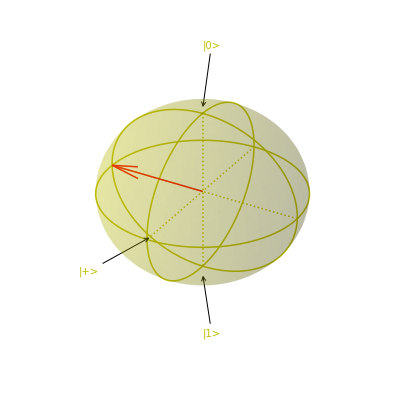

In [23]:
circ=Circuit().x(0).h(0).s(0)
draw_circuit(circ)

Matrix:
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [1.] pi |1>
 
Bloch Sphere:


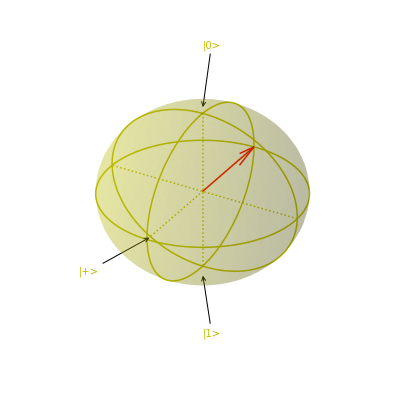

array([[ 0.70710678+0.j],
       [-0.70710678+0.j]])

In [20]:
draw_bloch(arr_h @ arr_x @ arr_0)

## The Bloch Clock

In [44]:
def bloch_clock():
    from time import gmtime
    import datetime
    import numpy as np
    time=gmtime()
    #set to EDT
    HR=time.tm_hour-4
    if HR<0:
        HR=HR+24
    MIN=time.tm_min
    SEC=time.tm_sec
    HR=11
    MIN=35
    SEC=30
    print('HR:',HR, 'MIN:',MIN, 'SEC:', SEC, 'EDT')
    circ=Circuit().ry(0,-(HR+MIN/60+SEC/3600)*np.pi/24).rz(0,-(MIN+SEC/60)*2*np.pi/60)
    draw_circuit(circ)

HR: 11 MIN: 35 SEC: 30 EDT
T  : |    0    |    1    |
                          
q0 : -Ry(-1.52)-Rz(-3.72)-

T  : |    0    |    1    |

Additional result types: StateVector
Matrix:
[[-0.20612405+0.69586314j]
 [ 0.19539087+0.65962852j]]
 
State Vector: |psi> = sqrt( [0.52671263] ) |0> + ( sqrt( [0.47328737] )) e^i [-0.18333333] pi |1>
 
Bloch Sphere:


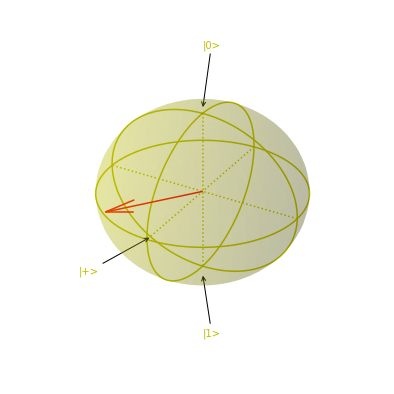

In [45]:
bloch_clock()

The diagram below shows how the Bloch Clock tracks time through the day

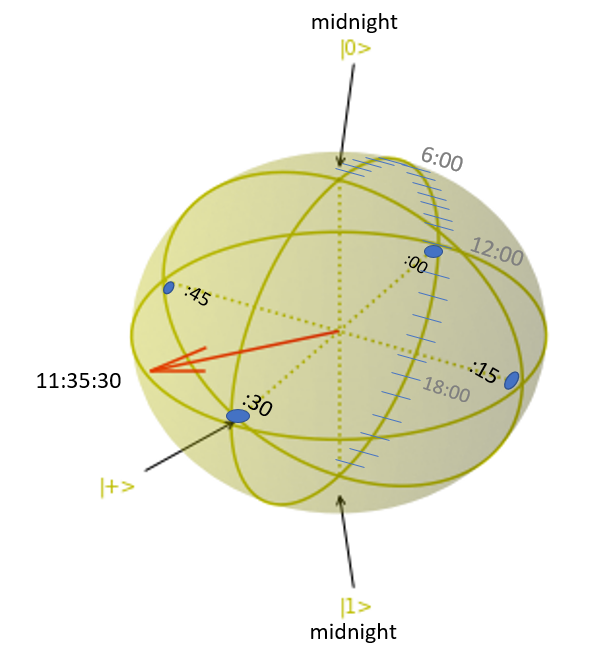

## Multiple Qubit Gates and Circuits

Using kronecker product to multiple two matrices

$$
\left[\begin{array}{cc} 
1 \\
0
\end{array}\right]
\bigotimes
\left[\begin{array}{cc} 
1 \\
0
\end{array}\right]
\bigotimes
\left[\begin{array}{cc} 
1 \\ 
0
\end{array}\right]
=
\left[\begin{array}{cc} 
1 \\ 
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{array}\right]
$$


In [57]:
arr_psi_i=np.kron(arr_0,np.kron(arr_0, arr_0))
print(arr_psi_i)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


In [56]:
#U1
arr_U1=np.kron(arr_h,np.kron(arr_h, arr_h))
print(arr_U1)

[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]
 [ 0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339 -0.35355339
   0.35355339 -0.35355339]
 [ 0.35355339  0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339
  -0.35355339 -0.35355339]
 [ 0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339 -0.35355339
  -0.35355339  0.35355339]
 [ 0.35355339  0.35355339  0.35355339  0.35355339 -0.35355339 -0.35355339
  -0.35355339 -0.35355339]
 [ 0.35355339 -0.35355339  0.35355339 -0.35355339 -0.35355339  0.35355339
  -0.35355339  0.35355339]
 [ 0.35355339  0.35355339 -0.35355339 -0.35355339 -0.35355339 -0.35355339
   0.35355339  0.35355339]
 [ 0.35355339 -0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339
   0.35355339 -0.35355339]]


In [58]:
# Psi_1
arr_psi_1= arr_U1 @ arr_psi_i
print(arr_psi_1)

[[0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]]


In [76]:
def run_circuit_local(circ):
    # This function prints the quantum circuit and calculates the final state vector
    # This can be used for multiple qubits and only uses the local simulator
    # The Bloch sphere is not printed
    circ=circ.state_vector()
    print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array(result.values).T
    print(arr_r)
    return(arr_r)

In [106]:
# psi_1 using quantum circuit

circ_psi_1=Circuit().h([0,1,2])
result=run_circuit_local(circ_psi_1)


T  : |0|
        
q0 : -H-
        
q1 : -H-
        
q2 : -H-

T  : |0|

Additional result types: StateVector
[[0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]
 [0.35355339+0.j]]


In [107]:
arr_U2=np.kron(arr_x,np.kron(arr_y, arr_z))
print(arr_U2)

[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j -0.+0.j  0.+0.j  0.-1.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j  0.+1.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+0.j -0.+0.j  0.+0.j  0.-0.j  0.+0.j -0.+0.j]]


In [108]:
arr_psi_2=arr_U2 @ arr_psi_1
print(arr_psi_2)

[[0.-0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]]


In [109]:
circ_psi_2=circ_psi_1.x(0).y(1).z(2)
result=run_circuit_local(circ_psi_2)

T  : |0|1|
          
q0 : -H-X-
          
q1 : -H-Y-
          
q2 : -H-Z-

T  : |0|1|

Additional result types: StateVector
[[0.-0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]]


## two qubit CNOT gate

In [110]:
arr_cx=np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [ ]:
# start with the |10> state

$$
\left[\begin{array}{cc} 
0 \\
1
\end{array}\right]
\bigotimes
\left[\begin{array}{cc} 
1 \\ 
0
\end{array}\right]
=
\left[\begin{array}{cc} 
0 \\ 
0 \\
1 \\
0 \\
\end{array}\right]
$$

In [111]:
arr_10= np.kron(arr_1, arr_0)
print(arr_10)

[[0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]]


CNOT operator on the |10> state results in |11> and  

$$
\left[\begin{array}{cc} 
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 
\end{array}\right]
\left[\begin{array}{cc} 
0 \\ 
0 \\
1 \\
0
\end{array}\right]
=
\left[\begin{array}{cc} 
0 \\ 
0 \\
0 \\
1
\end{array}\right]
$$ 

and CNOT operator on the |11> state results in |10>

$$
\left[\begin{array}{cc} 
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 
\end{array}\right]
\left[\begin{array}{cc} 
0 \\ 
0 \\
0 \\
1
\end{array}\right]
=
\left[\begin{array}{cc} 
0 \\ 
0 \\
1 \\
0
\end{array}\right]
$$ 

In [112]:
# arr_11
arr_11= arr_cx @ arr_10
print(arr_11)

[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]]


Continue with the 3 qubit circuit

In [113]:
# U3 
arr_U3=np.kron(arr_i,arr_cx)
print(arr_U3)

[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


In [114]:
arr_psi_3=arr_U3 @ arr_psi_2
print(arr_psi_3)

[[0.-0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]]


In [115]:
circ_psi_3=circ_psi_2.i(0).cnot(1,2)
result=run_circuit_local(circ_psi_3)

T  : |0|1|2|
            
q0 : -H-X-I-
            
q1 : -H-Y-C-
          | 
q2 : -H-Z-X-

T  : |0|1|2|

Additional result types: StateVector
[[0.-0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]]


For reference we can build the whole circuit as follows:

In [130]:
circ_psi_3=Circuit().h([0,1,2]).x(0).y(1).z(2).i(0).cnot(1,2).h([0,1,2])
arr_psi_3=run_circuit_local(circ_psi_3)

T  : |0|1|2|3|
              
q0 : -H-X-I-H-
              
q1 : -H-Y-C-H-
          |   
q2 : -H-Z-X-H-

T  : |0|1|2|3|

Additional result types: StateVector
[[0.-2.36158002e-17j]
 [0.-1.00000000e+00j]
 [0.-1.26316153e-34j]
 [0.-9.52420783e-18j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]]


Counter({'001': 1000})


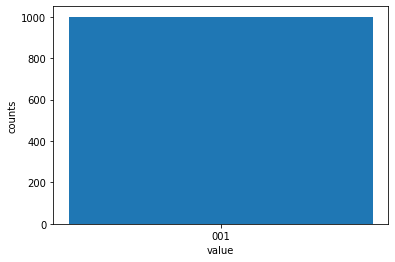

In [132]:
circ_psi_3=Circuit().h([0,1,2]).x(0).y(1).z(2).i(0).cnot(1,2).h([0,1,2])
device = LocalSimulator()
result = device.run(circ_psi_3, shots=1000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');

In [ ]:
### END HERE #####